In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import log_loss, accuracy_score, confusion_matrix,precision_recall_fscore_support
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV

In [2]:
df = pd.read_csv("live.csv")

In [3]:
df.head(5)

,Unnamed: 0,amt.pledged,blurb,by,country,currency,end.time,location,percentage.funded,state,title,type,url
0,0,15823.0,"\n'Catalysts, Explorers & Secret Keepers: Wome...",Museum of Science Fiction,US,usd,2016-11-01T23:59:00-04:00,"Washington, DC",186,DC,"Catalysts, Explorers & Secret Keepers: Women o...",Town,/projects/1608905146/catalysts-explorers-and-s...
1,1,6859.0,\nA unique handmade picture book for kids & ar...,"Tyrone Wells & Broken Eagle, LLC",US,usd,2016-11-25T01:13:33-05:00,"Portland, OR",8,OR,The Whatamagump (a hand-crafted story picture ...,Town,/projects/thewhatamagump/the-whatamagump-a-han...
2,2,17906.0,\nA horror comedy about a repairman who was in...,Tessa Stone,US,usd,2016-11-23T23:00:00-05:00,"Los Angeles, CA",102,CA,Not Drunk Enough Volume 1!,Town,/projects/1890925998/not-drunk-enough-volume-1...
3,3,67081.0,\nThe Johnny Wander autobio omnibus you've all...,Johnny Wander,US,usd,2016-11-01T23:50:00-04:00,"Brooklyn, NY",191,NY,Our Cats Are More Famous Than Us: A Johnny Wan...,County,/projects/746734715/our-cats-are-more-famous-t...
4,4,32772.0,\nThe vision for this project is the establish...,Beau's All Natural Brewing Company,RW,cad,2016-11-18T23:05:48-05:00,"Kigali, Rwanda",34,Kigali Province,The Rwanda Craft Brewery Project,Town,/projects/beaus/the-rwanda-craft-brewery-proje...


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 13 columns):
Unnamed: 0           4000 non-null int64
amt.pledged          4000 non-null float64
blurb                4000 non-null object
by                   4000 non-null object
country              3999 non-null object
currency             4000 non-null object
end.time             4000 non-null object
location             4000 non-null object
percentage.funded    4000 non-null int64
state                4000 non-null object
title                4000 non-null object
type                 4000 non-null object
url                  4000 non-null object
dtypes: float64(1), int64(2), object(10)
memory usage: 406.3+ KB


In [5]:
df=df[df["country"].notnull()]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3999 entries, 0 to 3999
Data columns (total 13 columns):
Unnamed: 0           3999 non-null int64
amt.pledged          3999 non-null float64
blurb                3999 non-null object
by                   3999 non-null object
country              3999 non-null object
currency             3999 non-null object
end.time             3999 non-null object
location             3999 non-null object
percentage.funded    3999 non-null int64
state                3999 non-null object
title                3999 non-null object
type                 3999 non-null object
url                  3999 non-null object
dtypes: float64(1), int64(2), object(10)
memory usage: 437.4+ KB


In [22]:
df["success"]=df["percentage.funded"]>=100 

In [23]:
df["currency"].value_counts()

usd    2661
eur     458
gbp     385
cad     224
aud     112
sgd      31
hkd      28
chf      25
sek      23
nzd      22
dkk      17
nok      13
Name: currency, dtype: int64

In [24]:
def perusd(x):
    if x.currency=="usd":
        return x["amt.pledged"]*1
    elif x.currency=="eur":
        return x["amt.pledged"]*1.09814
    elif x.currency=="gbp":
        return x["amt.pledged"]*1.21852
    elif x.currency=="cad":
        return x["amt.pledged"]*0.7467
    elif x.currency=="aud":
        return x["amt.pledged"]*0.75942
    elif x.currency=="sgd":
        return x["amt.pledged"]*0.7179
    elif x.currency=="hkd":
        return x["amt.pledged"]*0.12892
    elif x.currency=="chf":
        return x["amt.pledged"]*1.0103
    elif x.currency=="sek":
        return x["amt.pledged"]*0.1103
    elif x.currency=="nzd":
        return x["amt.pledged"]*0.71620
    elif x.currency=="dkk":
        return x["amt.pledged"]*0.1470
    elif x.currency=="nok":
        return x["amt.pledged"]*0.12082

In [25]:
df["usd"]=df.apply(perusd,axis=1)

In [26]:
df_analyze = df[["success","usd","country","type"]]

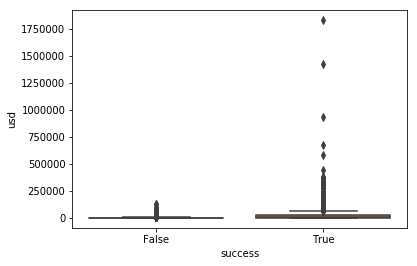

In [27]:
sns.boxplot(x="success",y="usd",data=df_analyze)

In [28]:
df_analyze = df_analyze[df["usd"]<=500000]

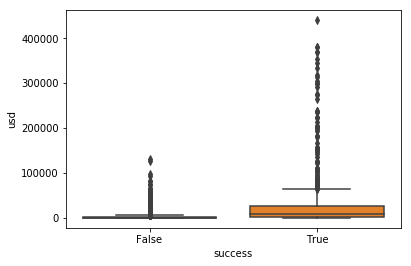

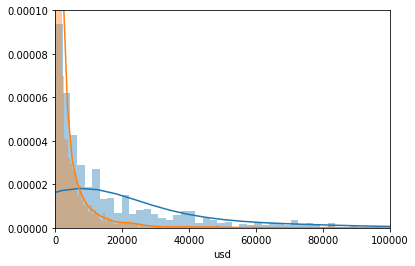

In [29]:
sns.boxplot(x="success",y="usd",data=df_analyze)
plt.show()
sns.distplot(df_analyze[df_analyze["success"]]["usd"],bins=200)
sns.distplot(df_analyze[~df_analyze["success"]]["usd"],bins=200)
plt.xlim([0,100000])
plt.ylim([0,1e-4])
plt.show()

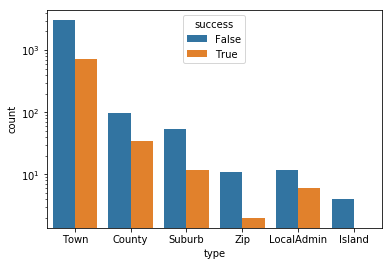

In [30]:
sns.countplot(x="type",hue="success",data=df_analyze)
plt.yscale("log")

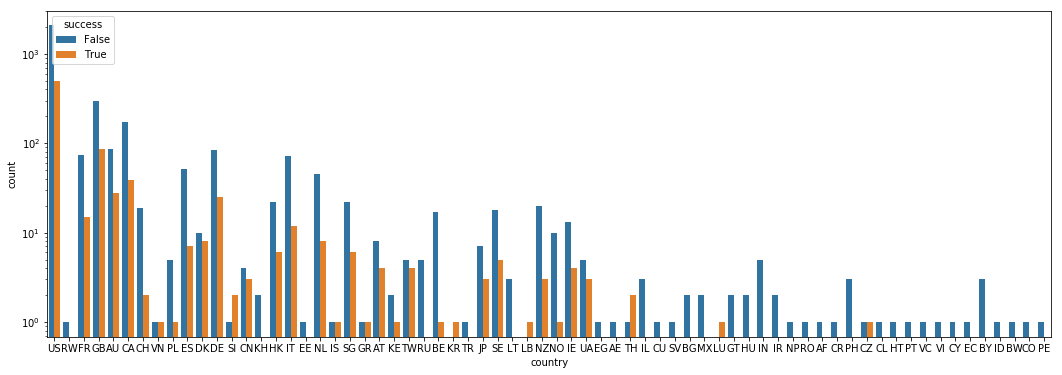

In [31]:
plt.figure(figsize=(18,6))
sns.countplot(x="country",hue="success",data=df_analyze)
plt.yscale("log")

In [34]:
mms=MinMaxScaler()
df_analyze["usd.norm"]=mms.fit_transform(df_analyze[["usd"]].values)

## ロジスティクス回帰

In [36]:
x=pd.get_dummies(df_analyze[["usd.norm","country","type"]]).values
y=df_analyze[["success"]].values

In [37]:
clf=SGDClassifier(loss="log",penalty="none",max_iter=10000,fit_intercept=True,random_state=1234,tol=1e-3)
clf.fit(x,y)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=10000,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='none',
       power_t=0.5, random_state=1234, shuffle=True, tol=0.001,
       validation_fraction=0.1, verbose=0, warm_start=False)

In [38]:
y_est= clf.predict(x)
y_proba= clf.predict_proba(x)
print('対数尤度 = {:.3f}'.format(- log_loss(y, y_proba, normalize=False)))
print('正答率 = {:.3f}%'.format(100 * accuracy_score(y, y_est)))

precision, recall, f1_score, _ = precision_recall_fscore_support(y, y_est)

print('適合率（Precision） = {:.3f}%'.format(100 * precision[1]))
print('再現率（Recall） = {:.3f}%'.format(100 * recall[1]))
print('F1値（F1-score） = {:.3f}%'.format(100 * f1_score[1]))

対数尤度 = -1650.887
正答率 = 84.502%
適合率（Precision） = 79.856%
再現率（Recall） = 28.280%
F1値（F1-score） = 41.769%


In [39]:
conf_mat = pd.DataFrame(confusion_matrix(y, y_est), 
                        index=['正解 = fail', '正解 = success'], 
                        columns=['予測 = fail', '予測 = success'])
conf_mat

,予測 = fail,予測 = success
正解 = fail,3153,56
正解 = success,563,222


## SVM

In [65]:
x=pd.get_dummies(df_analyze[["usd.norm","country","type"]]).values
y=df_analyze[["success"]].values

x_train, x_test, y_train ,y_test = train_test_split(x,y,test_size=0.3)

In [91]:
param = {"kernel":["linear","rbf"],"C":[1,5]}
model = SVC(gamma="scale")
clf= GridSearchCV(model,param,cv=3)
clf.fit(x_train, y_train)

clf_best=SVC(**clf.best_params_,gamma="scale")
clf_best.fit(x_train,y_train)


y_est= clf_best.predict(x_test)
print('正答率 = {:.3f}%'.format(100 * accuracy_score(y_test, y_est)))

precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_est)

print('適合率（Precision） = {:.3f}%'.format(100 * precision[1]))
print('再現率（Recall） = {:.3f}%'.format(100 * recall[1]))
print('F1値（F1-score） = {:.3f}%'.format(100 * f1_score[1]))

conf_mat = pd.DataFrame(confusion_matrix(y_test, y_est), 
                        index=['正解 = fail', '正解 = success'], 
                        columns=['予測 = fail', '予測 = success'])
conf_mat


正答率 = 80.817%
適合率（Precision） = 70.909%
再現率（Recall） = 15.415%
F1値（F1-score） = 25.325%


AttributeError: 'SVC' object has no attribute 'feature_importances_'

## AdaBoost

In [67]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

In [82]:
x_columns=pd.get_dummies(df_analyze[["usd.norm","country","type"]]).columns

正答率 = 77.398%
適合率（Precision） = 45.909%
再現率（Recall） = 39.921%
F1値（F1-score） = 42.706%


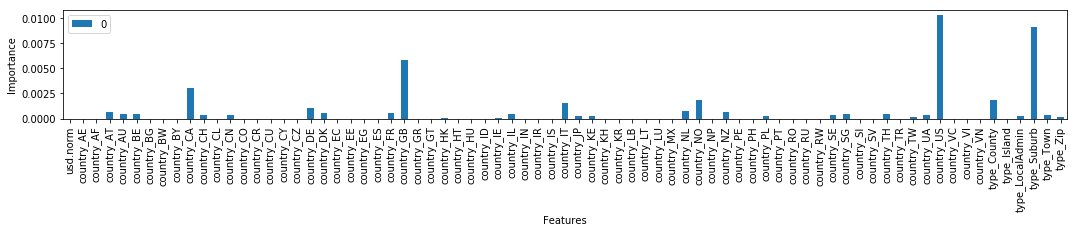

In [90]:
clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=10,
                                                                                min_samples_leaf=2,
                                                                                min_samples_split=2, 
                                                                                random_state=1234,
                                                                                criterion="gini"),
                                                                                n_estimators=100, random_state=1234)

                                                                            
clf.fit(x_train, y_train)
y_est = clf.predict(x_test)
print('正答率 = {:.3f}%'.format(100 * accuracy_score(y_test, y_est)))

precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_est)

print('適合率（Precision） = {:.3f}%'.format(100 * precision[1]))
print('再現率（Recall） = {:.3f}%'.format(100 * recall[1]))
print('F1値（F1-score） = {:.3f}%'.format(100 * f1_score[1]))

conf_mat = pd.DataFrame(confusion_matrix(y_test, y_est), 
                        index=['正解 = fail', '正解 = success'], 
                        columns=['予測 = fail', '予測 = success'])
conf_mat

pd.DataFrame(clf.feature_importances_, index=x_columns).plot.bar(figsize=(18,2))
plt.ylabel("Importance")
plt.xlabel("Features")
plt.show()